In [ ]:
import os
os.environ["MUJOCO_GL"] = "egl"

import mujoco
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [ ]:
def str_to_vec(str):
    return np.array([float(s) for s in str.split(" ")])

def vec_to_str(vec):
    return str(vec).replace('[', '').replace(']', '')

def add_exoskeleton_to_xml(xml, apply_exo_to=['thigh', 'leg', 'foot']):
    '''
    Add geometry and actuators to an existing scene to represent an exoskeleton.
    This function will add geometry to any body that contains a substring present in `apply_exo_to`.
    '''
    tree = ET.fromstring(xml)
    bodies = tree.findall('.//body')

    # the bodies to which we must add a exoskeleton geom
    exo_bodies = [body for body in bodies if any(substring in body.attrib['name'] for substring in apply_exo_to)]

    for b in exo_bodies:
        reference_geom = b.find('geom')
        exo_geom = reference_geom.attrib.copy()

        exo_geom['name'] = "exo_" + exo_geom['name']
        exo_geom['rgba'] = "1.0 0.0 0.0 1.0"

        exo_geom['type'] = 'box'
        size = str_to_vec(exo_geom['size'])
        size = np.array([size[0] * 0.5, 0.1, size[1] * 0.8])
        exo_geom['size'] = vec_to_str(size)
        
        ET.SubElement(b, 'geom', attrib=exo_geom)

    # add exoskeleton actuators
    actuator = tree.find('actuator')
    exo_motors = [motor for motor in actuator.iter('motor') if any(substring in motor.attrib['name'] for substring in apply_exo_to)]

    for motor in exo_motors:
        exo_motor = motor.attrib.copy()
        exo_motor['name'] = "exo_" + exo_motor['name']
        ET.SubElement(actuator, 'motor', attrib=exo_motor)

    return ET.tostring(tree, encoding='utf-8').decode('utf-8')

In [68]:
with open('./assets/walker2d.xml', 'r') as f:
    unmodified_xml = f.read()

modified_xml = add_exoskeleton_to_xml(unmodified_xml)

with open('./assets/walker2d_exo.xml', 'w') as f:
    f.write(modified_xml)

""

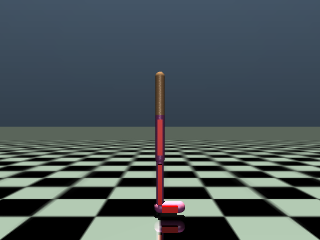

In [43]:
model = mujoco.MjModel.from_xml_string(modified_xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera='track')
  
  media.show_image(renderer.render())